## Review of Last week

Last week we made the collaborative filtering library from scratch. 

### In the `learner.py` file

CollaborativeFilterDataset Generator

```python
class CollabFilterDataset(Dataset):
    def __init__(self, path, user_col, item_col, ratings):
        self.ratings,self.path = ratings.values.astype(np.float32),path
        self.n = len(ratings)
        (self.users,self.user2idx,self.user_col,self.n_users) = self.proc_col(user_col)
        (self.items,self.item2idx,self.item_col,self.n_items) = self.proc_col(item_col)
        self.min_score,self.max_score = min(ratings),max(ratings)
        self.cols = [self.user_col,self.item_col,self.ratings]

    @classmethod
    def from_data_frame(cls, path, df, user_name, item_name, rating_name):
        return cls(path, df[user_name], df[item_name], df[rating_name])

    @classmethod
    def from_csv(cls, path, csv, user_name, item_name, rating_name):
        df = pd.read_csv(os.path.join(path,csv))
        return cls.from_data_frame(path, df, user_name, item_name, rating_name)

    def proc_col(self,col):
        uniq = col.unique()
        name2idx = {o:i for i,o in enumerate(uniq)}
        return (uniq, name2idx, np.array([name2idx[x] for x in col]), len(uniq))

    def __len__(self): return self.n
    def __getitem__(self, idx): return [o[idx] for o in self.cols]

    def get_data(self, val_idxs, bs):
        val, trn = zip(*split_by_idx(val_idxs, *self.cols))
        return ColumnarModelData(self.path, PassthruDataset(*trn), PassthruDataset(*val), bs)

    def get_model(self, n_factors):
        model = EmbeddingDotBias(n_factors, self.n_users, self.n_items, self.min_score, self.max_score)
        return CollabFilterModel(to_gpu(model))

    def get_learner(self, n_factors, val_idxs, bs, **kwargs):
        return CollabFilterLearner(self.get_data(val_idxs, bs), self.get_model(n_factors), **kwargs)
        
```


```python
def get_emb(ni,nf):
    e = nn.Embedding(ni, nf)
    e.weight.data.uniform_(-0.05,0.05)
    return e

class EmbeddingDotBias(nn.Module):
    def __init__(self, n_factors, n_users, n_items, min_score, max_score):
        super().__init__()
        self.min_score,self.max_score = min_score,max_score
        (self.u, self.i, self.ub, self.ib) = [get_emb(*o) for o in [
            (n_users, n_factors), (n_items, n_factors), (n_users,1), (n_items,1)
        ]]

    def forward(self, users, items):
        um = self.u(users)* self.i(items)
        res = um.sum(1) + self.ub(users).squeeze() + self.ib(items).squeeze()
        return F.sigmoid(res) * (self.max_score-self.min_score) + self.min_score

class CollabFilterLearner(Learner):
    def __init__(self, data, models, **kwargs):
        super().__init__(data, models, **kwargs)
        self.crit = F.mse_loss

class CollabFilterModel(BasicModel):
    def get_layer_groups(self): return self.model
```

In [1]:
from torch import nn
class EmbeddingNet(nn.Module):
    def __init__(self, n_users, n_movies, nh=10, p1=0.05, p2=0.5):
        super().__init__()
        (self.u, self.m) = [get_emb(*o) for o in [
            (n_users, n_factors), (n_movies, n_factors)]]
        self.lin1 = nn.Linear(n_factors*2, nh)
        self.lin2 = nn.Linear(nh, 1)
        self.drop1 = nn.Dropout(p1)
        self.drop2 = nn.Dropout(p2)
        
    def forward(self, cats, conts):
        users,movies = cats[:,0],cats[:,1]
        x = self.drop1(torch.cat([self.u(users),self.m(movies)], dim=1))
        x = self.drop2(F.relu(self.lin1(x)))
        return F.sigmoid(self.lin2(x)) * (max_rating-min_rating+1) + min_rating-0.5

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import sys
sys.path.append('../repos/fastai')
from fastai.learner import *
from fastai.column_data import *

path='ml-latest-small/'
ratings = pd.read_csv(path+'ratings.csv')
ratings.head()

val_idxs = get_cv_idxs(len(ratings))
wd=2e-4
n_factors = 50
movies = pd.read_csv(path+'movies.csv')
print(movies.shape, ratings.shape)


(9125, 3) (100004, 4)


In [3]:
cf = CollabFilterDataset.from_csv(path, 'ratings.csv', 'userId', 'movieId', 'rating')
learn = cf.get_learner(n_factors, val_idxs, 64, opt_fn=optim.Adam)

In [4]:
movie_names = movies.set_index('movieId')['title'].to_dict()
g=ratings.groupby('movieId')['rating'].count()
topMovies=g.sort_values(ascending=False).index.values[:3000]
topMovieIdx = np.array([cf.item2idx[o] for o in topMovies])

## Bias
each movie has its own bias

#### To take a look at hte layers of our pytorch model

In [5]:
m=learn.model; m

EmbeddingDotBias (
  (u): Embedding(671, 50)
  (i): Embedding(9066, 50)
  (ub): Embedding(671, 1)
  (ib): Embedding(9066, 1)
)

Layers require `Variables` because we need to keep track of the derivatives. The newest version of pytorch will get rid of variables, and it will all be native / built in.

In [6]:
movie_bias = to_np(m.ib(V(topMovieIdx)))

    EmbeddingDotBias (
      (u): Embedding(671, 50)
      (i): Embedding(9066, 50)
      (ub): Embedding(671, 1)
      (ib): Embedding(9066, 1)
    )


### Let's chek one of the variables

In [7]:
m.ib(V(topMovieIdx))

Variable containing:
1.00000e-02 *
 2.3116
-1.7544
 1.2235
   ⋮    
 4.6716
-1.8622
 1.1731
[torch.cuda.FloatTensor of size 3000x1 (GPU 0)]

In [8]:
movie_ratings = [(b[0], movie_names[i]) for i,b in zip(topMovies,movie_bias)]

### What are the worst movies?

In [9]:
sorted(movie_ratings, key=lambda o: o[0])[:15]

[(-0.049937896, 'Sin City (2005)'),
 (-0.049869832, 'Winnie the Pooh and the Blustery Day (1968)'),
 (-0.049756341, 'Bringing Down the House (2003)'),
 (-0.049732186, 'Maltese Falcon, The (1941)'),
 (-0.049730305, 'Fish Called Wanda, A (1988)'),
 (-0.049677063, 'Nell (1994)'),
 (-0.049676962, 'Spirited Away (Sen to Chihiro no kamikakushi) (2001)'),
 (-0.049667355, 'Sunshine (2007)'),
 (-0.049643833, 'Cider House Rules, The (1999)'),
 (-0.049607702, '2001: A Space Odyssey (1968)'),
 (-0.049597319, 'Penelope (2006)'),
 (-0.049578078, 'Inconvenient Truth, An (2006)'),
 (-0.049529426, 'Out of Sight (1998)'),
 (-0.049520683, "Coal Miner's Daughter (1980)"),
 (-0.049472842, 'Far from Heaven (2002)')]

In [10]:
sorted(movie_ratings, key=itemgetter(0))[:15]

[(-0.049937896, 'Sin City (2005)'),
 (-0.049869832, 'Winnie the Pooh and the Blustery Day (1968)'),
 (-0.049756341, 'Bringing Down the House (2003)'),
 (-0.049732186, 'Maltese Falcon, The (1941)'),
 (-0.049730305, 'Fish Called Wanda, A (1988)'),
 (-0.049677063, 'Nell (1994)'),
 (-0.049676962, 'Spirited Away (Sen to Chihiro no kamikakushi) (2001)'),
 (-0.049667355, 'Sunshine (2007)'),
 (-0.049643833, 'Cider House Rules, The (1999)'),
 (-0.049607702, '2001: A Space Odyssey (1968)'),
 (-0.049597319, 'Penelope (2006)'),
 (-0.049578078, 'Inconvenient Truth, An (2006)'),
 (-0.049529426, 'Out of Sight (1998)'),
 (-0.049520683, "Coal Miner's Daughter (1980)"),
 (-0.049472842, 'Far from Heaven (2002)')]

### What's the best movie?

In [11]:
sorted(movie_ratings, key=lambda o: o[0], reverse=True)[:15]

[(0.049996726, 'Basquiat (1996)'),
 (0.04998317, 'Grindhouse (2007)'),
 (0.04992019, 'Beneath the Planet of the Apes (1970)'),
 (0.049862832, 'Get Shorty (1995)'),
 (0.049845789, 'Night of the Living Dead (1968)'),
 (0.049809847, 'Tomorrow Never Dies (1997)'),
 (0.049781345, 'Glengarry Glen Ross (1992)'),
 (0.049769394, 'Misérables, Les (1995)'),
 (0.049750172, 'From Hell (2001)'),
 (0.049735427, 'Catwoman (2004)'),
 (0.049725704, 'Battleship Potemkin (1925)'),
 (0.049607269, 'Bone Collector, The (1999)'),
 (0.049606908, 'Perfume: The Story of a Murderer (2006)'),
 (0.049585488, 'Frequency (2000)'),
 (0.049541574, "Ender's Game (2013)")]

## Embedding Interpretation

Let's try and flatten this space so that we can interpret it better. Some techniques to think about are : **pca** or **svd** which are decomposition methods to reduce our dimensionality

In [12]:
movie_emb = to_np(m.i(V(topMovieIdx)))
movie_emb.shape

(3000, 50)

#### We are reducing the 50 dimensionality to a 3-dimensional approximation

In [13]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
movie_pca = pca.fit(movie_emb.T).components_

In [14]:
movie_pca.shape

(3, 3000)

#### Lets look at the reduced dimensionality and interpret the meaning

In [15]:
fac0 = movie_pca[0]
movie_comp = [(f, movie_names[i]) for f,i in zip(fac0, topMovies)]

#### lets look at the 1st dimension: we call it easy watching vs. serious

In [16]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(0.054308776, 'Bonfire of the Vanities (1990)'),
 (0.052916676, 'Ex Machina (2015)'),
 (0.052070759, 'Falling Down (1993)'),
 (0.051866416, 'Nosferatu (Nosferatu, eine Symphonie des Grauens) (1922)'),
 (0.050818264, 'Quantum of Solace (2008)'),
 (0.050795961, 'Lilies of the Field (1963)'),
 (0.049873799, 'Illusionist, The (2006)'),
 (0.049717102, 'Ronin (1998)'),
 (0.049355291, 'Bitter Moon (1992)'),
 (0.048397031, 'Ella Enchanted (2004)')]

In [17]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(-0.06548804, 'Hate (Haine, La) (1995)'),
 (-0.054825306, 'Sandlot, The (1993)'),
 (-0.053414859, 'Ruthless People (1986)'),
 (-0.052211139, 'Simple Plan, A (1998)'),
 (-0.051708255, 'Hairspray (1988)'),
 (-0.049773846, 'Little Miss Sunshine (2006)'),
 (-0.048778363, 'Black Beauty (1994)'),
 (-0.048621822, 'Bonnie and Clyde (1967)'),
 (-0.048216734, 'Kids (1995)'),
 (-0.047948148, 'Tank Girl (1995)')]

#### let's look at the 2nd dimension

In [18]:
fac1 = movie_pca[1]
movie_comp = [(f, movie_names[i]) for f,i in zip(fac1, topMovies)]

#### 2nd dim best

In [19]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(0.065224506, 'Kiss the Girls (1997)'),
 (0.059658531, 'Fiddler on the Roof (1971)'),
 (0.05408306, 'RoboCop (2014)'),
 (0.053201783, 'Frenzy (1972)'),
 (0.052245513, 'American Gangster (2007)'),
 (0.050967816, 'Cutting Edge, The (1992)'),
 (0.050565537, 'Reindeer Games (2000)'),
 (0.05018561, 'Hearts of Darkness: A Filmmakers Apocalypse (1991)'),
 (0.049161926, 'Badlands (1973)'),
 (0.048389364, 'Mad Max: Fury Road (2015)')]

#### 2nd dim worst

In [20]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(-0.063395478, 'Pollyanna (1960)'),
 (-0.06290257, "Monster's Ball (2001)"),
 (-0.058774415, 'Mexican, The (2001)'),
 (-0.058014624, 'Tin Men (1987)'),
 (-0.056430273, 'Mad City (1997)'),
 (-0.055390898, 'Men in Black II (a.k.a. MIIB) (a.k.a. MIB 2) (2002)'),
 (-0.055204011, 'Identity (2003)'),
 (-0.053047962, 'Fear (1996)'),
 (-0.052593146, 'Underworld: Rise of the Lycans (2009)'),
 (-0.050690483, 'Wedding Singer, The (1998)')]

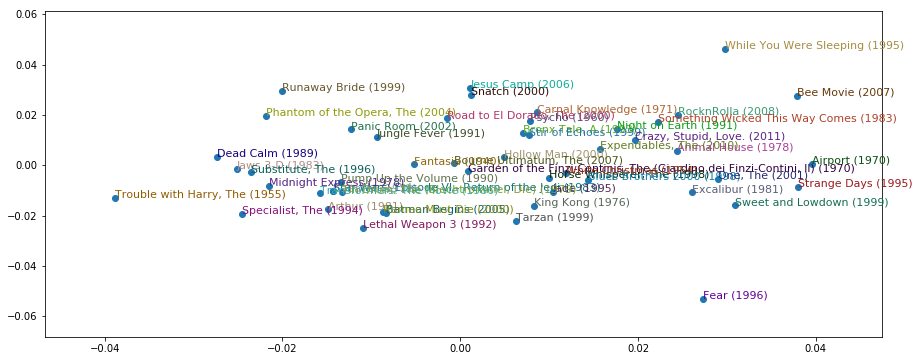

In [21]:
idxs = np.random.choice(len(topMovies), 50, replace=False)
X = fac0[idxs]
Y = fac1[idxs]
plt.figure(figsize=(15,6))
plt.scatter(X, Y)
for i, x, y in zip(topMovies[idxs], X, Y):
    plt.text(x,y,movie_names[i], color=np.random.rand(3)*0.7, fontsize=11)
plt.show()

## Entity Embedding Layer
https://arxiv.org/pdf/1604.06737

<img src='https://cdn-images-1.medium.com/max/793/1*fwNpdhYLc0awJyaPlt3SPw.png' style='width:500px'/>

What if we replace all the words as features, we replace them with the embeddings instead. And then run GBM on top of it. This uses embedding of stores as a intermediate transformation and then run random forest or GBM on top of it. You can even use KNN on top of it and get a lot of improvement.

GBMs and RF train a lot faster than NN.

#### They also tried using embeddings to plot the cities in germany

#### they also tried using embeddings to understand the closeness of stores vs. the embeddings of stores

#### They also did embeddings on days of the week, or months

### Question on Skipgram to generate embeddings -> Discussion on Word2Vec

Started one sentence, and replaces 1 word with another cat. Then they made labels 1 if it was unchanged, and 0 if it was changed. And the model will try to find the fake sentences, but as a result, they have embeddings for other purposes. If you do this as matrix multiplier, (shallow), you can train this very quickly

- can train on big dataset
- embeddings that have really linear characteristics

Ideally we need to move away from Word2Vec, its not very good at predictive power. The new state of the art is Language models with a deep RNN.

#### You either need labeled data, or you need to invent a task that will generate that 

- ideally a task where the kinds of relationships are transferrable to the ideal task
- in computer vision, lets recolor images, and have the NN guess if its been edited or not
- try and come up with more clever fake tasks.
- **`Auto Encoder`** - force a large amount of variables down into a smaller layer, then back out again.

In computer vision, you can train on cats and dogs and use it for CT scans.  Maybe it might work for language / NLP! (future research)

### Aside on Rossman (from lesson 3)

- Talking about embedding
- Looking at sunday effects
- not looking at the EDA for store closure.

- `MixedInputModel` was used

```python

class MixedInputModel(nn.Module):
    def __init__(self, emb_szs, n_cont, emb_drop, out_sz, szs, drops,
                 y_range=None, use_bn=False):
        super().__init__()
                
        self.embs = nn.ModuleList([nn.Embedding(c, s) for c,s in emb_szs])        
        for emb in self.embs: emb_init(emb)
        n_emb = sum(e.embedding_dim for e in self.embs)
        szs = [n_emb+n_cont] + szs
        self.lins = nn.ModuleList([
            nn.Linear(szs[i], szs[i+1]) for i in range(len(szs)-1)])
        self.bns = nn.ModuleList([
            nn.BatchNorm1d(sz) for sz in szs[1:]])
        for o in self.lins: kaiming_normal(o.weight.data)
        self.outp = nn.Linear(szs[-1], out_sz)
        kaiming_normal(self.outp.weight.data)

        self.emb_drop = nn.Dropout(emb_drop)
        self.drops = nn.ModuleList([nn.Dropout(drop) for drop in drops])
        self.bn = nn.BatchNorm1d(n_cont)
        self.use_bn,self.y_range = use_bn,y_range

    def forward(self, x_cat, x_cont):
        x = [e(x_cat[:,i]) for i,e in enumerate(self.embs)]
        x = torch.cat(x, 1)
        x2 = self.bn(x_cont)
        x = self.emb_drop(x)
        x = torch.cat([x, x2], 1)
        for l,d,b in zip(self.lins, self.drops, self.bns):
            x = F.relu(l(x))
            if self.use_bn: x = b(x)
            x = d(x)
        x = self.outp(x)
        if self.y_range:
            x = F.sigmoid(x)
            x = x*(self.y_range[1] - self.y_range[0])
            x = x+self.y_range[0]
        return x
```


### A Layer Deeper what does `.fit()` do?

# SGD

Let's work on solving a simple case of `Ax + b`. If we can do this we can apply teh technique to other problems as well.

In [22]:
import torch

In [23]:
import sys
sys.path.append('../repos/fastai')
%matplotlib inline
from fastai.learner import *
from matplotlib import rcParams, animation, rc
from ipywidgets import interact, interactive, fixed
from ipywidgets.widgets import *
rc('animation', html='html5')
rcParams['figure.figsize'] = 3, 3

#### First let's generate some fake data

In [24]:
# Here we generate some fake data
def lin(a,b,x): return a*x+b

def gen_fake_data(n, a, b):
    x = s = np.random.uniform(0,1,n) 
    y = lin(a,b,x) + 0.1 * np.random.normal(0,3,n)
    return x, y

x, y = gen_fake_data(50, 3., 8.)

###  a linear regression loss function

In [25]:
def mse(y_hat, y): return ((y_hat - y) ** 2).mean()

In [26]:
def mse_loss(a, b, x, y): return mse(lin(a,b,x), y)

#### let's test it out between 5 and 10

In [27]:
mse_loss(10, 5, x, y)

4.3865950349551408

In [28]:
# generate some more data
x, y = gen_fake_data(10000, 3., 8.)
x.shape, y.shape

((10000,), (10000,))

In [29]:
#### label these as variables so that pytorch will do the differentials

In [30]:
x,y = V(x),V(y)

#### Lets start initializing some weights

In [31]:
# Create random weights a and b, and wrap them in Variables.
a = V(np.random.randn(1), requires_grad=True)
b = V(np.random.randn(1), requires_grad=True)
a,b

(Variable containing:
  0.5666
 [torch.FloatTensor of size 1], Variable containing:
  1.1612
 [torch.FloatTensor of size 1])

### The gradient loop `optim.sgd.step ...`

- `.grad` is where pytorch calculates the differential
- then we nudge the `a` and `b` tensors in the direction of the gradient
- you have to tell the gradients back to zero
- `zero_()` the `_` means that the variable is changed in place


In [32]:
learning_rate = 1e-3
for t in range(10000):
    # Forward pass: compute predicted y using operations on Variables
    loss = mse_loss(a,b,x,y)
    if t % 1000 == 0: print(loss.data[0])
    
    # Computes the gradient of loss with respect to all Variables with requires_grad=True.
    # After this call a.grad and b.grad will be Variables holding the gradient
    # of the loss with respect to a and b respectively
    loss.backward()
    
    # Update a and b using gradient descent; a.data and b.data are Tensors,
    # a.grad and b.grad are Variables and a.grad.data and b.grad.data are Tensors
    a.data -= learning_rate * a.grad.data
    b.data -= learning_rate * b.grad.data
    
    # Zero the gradients
    a.grad.data.zero_()
    b.grad.data.zero_()    

65.58589172363281
0.5537242889404297
0.1400136947631836
0.1267116665840149
0.1183580830693245
0.11194716393947601
0.10701844841241837
0.10322901606559753
0.100315622985363
0.0980757400393486


### Can you do this with Numpy?

In [33]:
x, y = gen_fake_data(50, 3., 8.)

In [34]:
def rmse_loss(y,a,b,x): return np.sqrt(mse_loss(y,a,b,x))

In [35]:
a_guess,b_guess = -1., 1.
rmse_loss(y, a_guess, b_guess, x)

8.260525377243658

In [36]:
lr=0.01
def upd():
    global a_guess, b_guess
    y_pred = lin(a_guess, b_guess, x)
    dydb = 2 * (y_pred - y)
    dyda = x*dydb
    a_guess -= lr*dyda.mean()
    b_guess -= lr*dydb.mean()

### install ffmpeg

https://github.com/adaptlearning/adapt_authoring/wiki/Installing-FFmpeg

In [37]:
fig = plt.figure(dpi=100, figsize=(5, 4))
plt.scatter(x,y)
line, = plt.plot(x,lin(a_guess,b_guess,x))
plt.close()

def animate(i):
    line.set_ydata(lin(a_guess,b_guess,x))
    for i in range(30): upd()
    return line,

ani = animation.FuncAnimation(fig, animate, np.arange(0, 20), interval=100)
ani

KeyError: 'ffmpeg'

# RNN's!

<img src='https://cdn-images-1.medium.com/max/1600/1*zUcOFR_muw4y5vSv2yvWKw.png' style='width:400px' />

In [38]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.io import *
from fastai.conv_learner import *

from fastai.column_data import *

In [39]:
PATH='./'

In [40]:
get_data("https://s3.amazonaws.com/text-datasets/nietzsche.txt", f'{PATH}nietzsche.txt')
text = open(f'{PATH}nietzsche.txt').read()
print('corpus length:', len(text))

corpus length: 600893


### SwiftKey uses it
<img src='http://www.eyerys.com/sites/default/files/swiftkey-neural-model.png'  style='width:400px'/>

### Super simple 1 hidden layer NN

```python
Input : batchsize # inputs
Matrix product (linear)
Relu
Hidden layers () # activations batchsize x ct of hidden units
Matrix product (e.g. linear layer)
softmax
Output Activations # of classes
```

### Super simple 1 hidden layer CNN

```python
Input : batchsize # inputs
Convolution (stride 2)
Conv1 - filters 
Flatten - Adaptive max pooling (average height and width                               
Fully connected layer 
Matrix Product
Output classes # of classes
```

### Super simple hidden layer model 

- 2 hidden layer
- 3 matrix products

```python
Input : char 1 vocab size # inputs
Fully connected layer 1
Fully connected layer 2 <--- character 2 input
Char3 output: vocab size
```


In [41]:
text[:400]

'PREFACE\n\n\nSUPPOSING that Truth is a woman--what then? Is there not ground\nfor suspecting that all philosophers, in so far as they have been\ndogmatists, have failed to understand women--that the terrible\nseriousness and clumsy importunity with which they have usually paid\ntheir addresses to Truth, have been unskilled and unseemly methods for\nwinning a woman? Certainly she has never allowed herself '

#### lets look at all the unique letters

In [42]:
chars = sorted(list(set(text)))
vocab_size = len(chars)+1
print('total chars:', vocab_size)

total chars: 85


In [43]:
chars.insert(0, "\0")

In [44]:
''.join(chars[1:-6])

'\n !"\'(),-.0123456789:;=?ABCDEFGHIJKLMNOPQRSTUVWXYZ[]_abcdefghijklmnopqrstuvwxy'

#### Lets make a lookup for chars to int

In [45]:
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

In [46]:
idx = [char_indices[c] for c in text]

#### Each of these integers represent a character 

In [47]:
idx[:10]

[40, 42, 29, 30, 25, 27, 29, 1, 1, 1]

In [48]:
''.join(indices_char[i] for i in idx[:70])

'PREFACE\n\n\nSUPPOSING that Truth is a woman--what then? Is there not gro'

## Three Character Model

### Create inputs / targets

**GOAL:** Create a list of every 4th character, starting at the 0th, 1st, 2nd, then 3rd characters

Create some datasets

In [49]:
cs=3
c1_dat = [idx[i]   for i in range(0, len(idx)-1-cs, cs)]
c2_dat = [idx[i+1] for i in range(0, len(idx)-1-cs, cs)]
c3_dat = [idx[i+2] for i in range(0, len(idx)-1-cs, cs)]
c4_dat = [idx[i+3] for i in range(0, len(idx)-1-cs, cs)]

#### Here are the 0, 1, 2 characters

In [50]:
x1 = np.stack(c1_dat[:-2])
x2 = np.stack(c2_dat[:-2])
x3 = np.stack(c3_dat[:-2])

#### And our target variable, the 4th letter

In [51]:
y = np.stack(c4_dat[:-2])

In [52]:
x1[:4], x2[:4], x3[:4]

(array([40, 30, 29,  1]), array([42, 25,  1, 43]), array([29, 27,  1, 45]))

In [53]:
y[:4]

array([30, 29,  1, 40])

In [54]:
x1.shape, y.shape

((200295,), (200295,))

## Create the Simple Char Model

```python
Input : char 1 input # inputs
Fully connected layer 1
Fully connected layer 2 <--- character 2 input
Fully connected layer 3 <--- character 3 input
output: Char4 output
```

Set hidden layer size and the number of factors for the embedding matrix

In [55]:
n_hidden = 256
n_fac = 42

In [56]:
class Char3Model(nn.Module):
    def __init__(self, vocab_size, n_fac):
        super().__init__()
        
        ## embedding
        self.e = nn.Embedding(vocab_size, n_fac)

        # The 'green arrow' from our diagram - the layer operation from input to hidden
        self.l_in = nn.Linear(n_fac, n_hidden)

        # The 'orange arrow' from our diagram - the layer operation from hidden to hidden
        self.l_hidden = nn.Linear(n_hidden, n_hidden)
        
        # The 'blue arrow' from our diagram - the layer operation from hidden to output
        self.l_out = nn.Linear(n_hidden, vocab_size)
        
    def forward(self, c1, c2, c3):
        in1 = F.relu(self.l_in(self.e(c1)))
        in2 = F.relu(self.l_in(self.e(c2)))
        in3 = F.relu(self.l_in(self.e(c3)))
        
        h = V(torch.zeros(in1.size()).cuda())
        h = F.tanh(self.l_hidden(h+in1))
        h = F.tanh(self.l_hidden(h+in2))
        h = F.tanh(self.l_hidden(h+in3))
        
        return F.log_softmax(self.l_out(h))


` in1 = F.relu(self.l_in(self.e(c1)))`

Stick it through a linear layer, then a relu

`h = F.tanh(self.l_hidden(h+in1))`



In [57]:
md = ColumnarModelData.from_arrays('.', [-1], np.stack([x1,x2,x3], axis=1), y, bs=512)

### Create our pytorch model (above)

In [58]:
m = Char3Model(vocab_size, n_fac).cuda()

In [59]:
it = iter(md.trn_dl)
*xs,yt = next(it)
t = m(*V(xs))

In [60]:
t 

Variable containing:
-4.5326 -4.4424 -4.5330  ...  -4.2526 -4.8234 -4.1015
-4.5132 -4.3008 -4.5556  ...  -4.3550 -4.5121 -4.5760
-4.6016 -4.4866 -4.4367  ...  -4.3994 -4.4466 -4.3081
          ...             ⋱             ...          
-4.4800 -4.3987 -4.3505  ...  -4.2764 -4.6547 -4.7373
-4.5363 -4.4387 -4.5929  ...  -4.0393 -4.3796 -4.3961
-4.3588 -4.4949 -4.3115  ...  -4.1984 -4.5441 -4.6890
[torch.cuda.FloatTensor of size 512x85 (GPU 0)]

In [61]:
opt = optim.Adam(m.parameters(), 1e-2)

In [62]:
fit(m, md, 1, opt, F.nll_loss)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

[ 0.       2.09804  5.12998]                                



In [63]:
set_lrs(opt, 0.001)

In [64]:
fit(m, md, 1, opt, F.nll_loss)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

[ 0.       1.85502  4.3849 ]                                



### Let's test the model

In [65]:
def get_next(inp):
    idxs = T(np.array([char_indices[c] for c in inp]))
    p = m(*VV(idxs))
    i = np.argmax(to_np(p))
    return chars[i]

In [66]:
get_next('y. ')

'T'

In [67]:
get_next('ppl')

'e'

In [68]:
get_next(' th')

'e'

In [69]:
get_next('and')

' '

## Let's create an RNN


<img src='http://www.wildml.com/wp-content/uploads/2015/09/rnn.jpg' />
```python
Input : char 1 input # inputs
Fully connected layer 1
Fully connected layer 2 RECURSE <--- character n input depending on the loop
output: Char4 output
```


#### Create input

In [70]:
cs=8

For each of 0 through 7, create a list of every 8th character with that starting point. These will be the 8 inputs to out model.

In [71]:
c_in_dat = [[idx[i+j] for i in range(cs)] for j in range(len(idx)-cs-1)]

Then create a list of the next character in each of these series. This will be the labels for our model.

In [72]:
c_out_dat = [idx[j+cs] for j in range(len(idx)-cs-1)]

In [73]:
xs = np.stack(c_in_dat, axis=0)

In [74]:
xs.shape

(600884, 8)

In [75]:
y = np.stack(c_out_dat)

So each column below is one series of 8 characters from the text.

In [76]:
xs[:cs,:cs]

array([[40, 42, 29, 30, 25, 27, 29,  1],
       [42, 29, 30, 25, 27, 29,  1,  1],
       [29, 30, 25, 27, 29,  1,  1,  1],
       [30, 25, 27, 29,  1,  1,  1, 43],
       [25, 27, 29,  1,  1,  1, 43, 45],
       [27, 29,  1,  1,  1, 43, 45, 40],
       [29,  1,  1,  1, 43, 45, 40, 40],
       [ 1,  1,  1, 43, 45, 40, 40, 39]])

...and this is the next character after each sequence.

In [77]:
y[:cs]

array([ 1,  1, 43, 45, 40, 40, 39, 43])

In [78]:
val_idx = get_cv_idxs(len(idx)-cs-1)

In [79]:
md = ColumnarModelData.from_arrays('.', val_idx, xs, y, bs=512)

#### Note that we have a 8 layer network, due to the loop

In [80]:
class CharLoopModel(nn.Module):
    def __init__(self, vocab_size, n_fac):
        super().__init__()
        self.e = nn.Embedding(vocab_size, n_fac)
        self.l_in = nn.Linear(n_fac, n_hidden)
        self.l_hidden = nn.Linear(n_hidden, n_hidden)
        self.l_out = nn.Linear(n_hidden, vocab_size)
        
    def forward(self, *cs):
        bs = cs[0].size(0)
        h = V(torch.zeros(bs, n_hidden).cuda())
        
        #============= Our new loop ==============
        for c in cs:
            inp = F.relu(self.l_in(self.e(c)))
            h = F.tanh(self.l_hidden(h+inp))
        
        #============= Our new loop ==============
        
        return F.log_softmax(self.l_out(h))

In [81]:
m = CharLoopModel(vocab_size, n_fac).cuda()
opt = optim.Adam(m.parameters(), 1e-2)

In [82]:
fit(m, md, 1, opt, F.nll_loss)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

[ 0.       2.07544  2.0632 ]                                



In [83]:
set_lrs(opt, 0.001)

In [84]:
fit(m, md, 1, opt, F.nll_loss)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

[ 0.       1.77987  1.79123]                                



#### Adding two things together is a bit dangerous, now we will modify layer to concat instead of add

This way we will not lose information

In [85]:
class CharLoopConcatModel(nn.Module):
    def __init__(self, vocab_size, n_fac):
        super().__init__()
        self.e = nn.Embedding(vocab_size, n_fac)
        self.l_in = nn.Linear(n_fac+n_hidden, n_hidden)
        self.l_hidden = nn.Linear(n_hidden, n_hidden)
        self.l_out = nn.Linear(n_hidden, vocab_size)
        
    def forward(self, *cs):
        bs = cs[0].size(0)
        h = V(torch.zeros(bs, n_hidden).cuda())
        for c in cs:
            
            #============ replace =============
            inp = torch.cat((h, self.e(c)), 1)
            #============ replace =============            
            
            inp = F.relu(self.l_in(inp))
            h = F.tanh(self.l_hidden(inp))
        
        return F.log_softmax(self.l_out(h))

In [86]:
m = CharLoopConcatModel(vocab_size, n_fac).cuda()
opt = optim.Adam(m.parameters(), 1e-3)

In [87]:
it = iter(md.trn_dl)
*xs,yt = next(it)
t = m(*V(xs))

In [88]:
fit(m, md, 1, opt, F.nll_loss)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

[ 0.       1.80183  1.78611]                                



In [89]:
set_lrs(opt, 1e-4)

In [90]:
fit(m, md, 1, opt, F.nll_loss)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

[ 0.       1.68999  1.69335]                                



### Lets test our RNN

In [91]:
def get_next(inp):
    idxs = T(np.array([char_indices[c] for c in inp]))
    p = m(*VV(idxs))
    i = np.argmax(to_np(p))
    return chars[i]

In [92]:
get_next('for thos')

'e'

In [93]:
get_next('part of ')

't'

In [94]:
get_next('queens a')

'n'

## RNN in Pytorch. will make the layers for us for us

#### note that:
` outp,h = self.rnn(inp, h)` will give back a growing matrix (all hidden states)

#### quick comment
` h = V(torch.zeros(1, bs, n_hidden))` we can actually have two directions (forward and backwards), or we can also do a multilayer RNN

In [95]:
class CharRnn(nn.Module):
    def __init__(self, vocab_size, n_fac):
        super().__init__()
        self.e = nn.Embedding(vocab_size, n_fac)
        
        # ===== torch! =================
        self.rnn = nn.RNN(n_fac, n_hidden)
        # ===== torch! =================
        
        self.l_out = nn.Linear(n_hidden, vocab_size)
        
    def forward(self, *cs):
        bs = cs[0].size(0)
        h = V(torch.zeros(1, bs, n_hidden))
        inp = self.e(torch.stack(cs))
        
        # ===== torch! =================        
        outp,h = self.rnn(inp, h)
        # ===== torch! =================
        
        
        return F.log_softmax(self.l_out(outp[-1]))

In [96]:
m = CharRnn(vocab_size, n_fac).cuda()
opt = optim.Adam(m.parameters(), 1e-3)

In [97]:
it = iter(md.trn_dl)
*xs,yt = next(it)

In [98]:
t = m.e(V(torch.stack(xs)))
t.size()

torch.Size([8, 512, 42])

#### We can examine that last hidden state

In [99]:
ht = V(torch.zeros(1, 512,n_hidden))
outp, hn = m.rnn(t, ht)
outp.size(), hn.size()

(torch.Size([8, 512, 256]), torch.Size([1, 512, 256]))

In [100]:
t = m(*V(xs)); t.size()

torch.Size([512, 85])

In [101]:
fit(m, md, 4, opt, F.nll_loss)

HBox(children=(IntProgress(value=0, description='Epoch', max=4), HTML(value='')))

[ 0.       1.8626   1.85105]                                
[ 1.       1.67591  1.66735]                                
[ 2.       1.60083  1.59047]                                
[ 3.       1.52933  1.5452 ]                                



### Test the model

In [102]:
def get_next(inp):
    idxs = T(np.array([char_indices[c] for c in inp]))
    p = m(*VV(idxs))
    i = np.argmax(to_np(p))
    return chars[i]

In [103]:
get_next('for thos')

'e'

In [104]:
def get_next_n(inp, n):
    res = inp
    for i in range(n):
        c = get_next(inp)
        res += c
        inp = inp[1:]+c
    return res

### predict more than 1 character!

In [105]:
get_next_n('for thos', 40)

'for those the same the same the same the same th'

### Comment on efficiency

```python
array([[40, 42, 29, 30, 25, 27, 29,  1],
       [42, 29, 30, 25, 27, 29,  1,  1],
       [29, 30, 25, 27, 29,  1,  1,  1],
       [30, 25, 27, 29,  1,  1,  1, 43],
       [25, 27, 29,  1,  1,  1, 43, 45],
       [27, 29,  1,  1,  1, 43, 45, 40],
       [29,  1,  1,  1, 43, 45, 40, 40],
       [ 1,  1,  1, 43, 45, 40, 40, 39]])
```

There's a lot of similarity between the different rows. So lets rearrange

```python
array([[40, 42, 29, 30, 25, 27, 29,  1],
       [ 1,  1, 43, 45, 40, 40, 39, 43],
       [33, 38, 31,  2, 73, 61, 54, 73],
       [ 2, 44, 71, 74, 73, 61,  2, 62],
       [72,  2, 54,  2, 76, 68, 66, 54],
       [67,  9,  9, 76, 61, 54, 73,  2],
       [73, 61, 58, 67, 24,  2, 33, 72],
       [ 2, 73, 61, 58, 71, 58,  2, 67]])
```

```python
array([[42, 29, 30, 25, 27, 29,  1,  1],
       [ 1, 43, 45, 40, 40, 39, 43, 33],
       [38, 31,  2, 73, 61, 54, 73,  2],
       [44, 71, 74, 73, 61,  2, 62, 72],
       [ 2, 54,  2, 76, 68, 66, 54, 67],
       [ 9,  9, 76, 61, 54, 73,  2, 73],
       [61, 58, 67, 24,  2, 33, 72,  2],
       [73, 61, 58, 71, 58,  2, 67, 68]])
```

### Multioutput

```python
Input : char 1 input # inputs
Fully connected layer 1
# --------------------------- RECURSE
Fully connected layer 2  <--- character n input depending on the loop
output: Char4 output
# ---------------------------
```


we want non-overlappy character sets

In [106]:
c_in_dat = [[idx[i+j] for i in range(cs)] for j in range(0, len(idx)-cs-1, cs)]

Same thing but offset by 1 as our labels

In [107]:
c_out_dat = [[idx[i+j] for i in range(cs)] for j in range(1, len(idx)-cs, cs)]

In [108]:
xs = np.stack(c_in_dat)
xs.shape

(75111, 8)

In [109]:
ys = np.stack(c_out_dat)
ys.shape

(75111, 8)

In [110]:
val_idx = get_cv_idxs(len(xs)-cs-1)

In [111]:
md = ColumnarModelData.from_arrays('.', val_idx, xs, ys, bs=512)

In [112]:
class CharSeqRnn(nn.Module):
    def __init__(self, vocab_size, n_fac):
        super().__init__()
        self.e = nn.Embedding(vocab_size, n_fac)
        self.rnn = nn.RNN(n_fac, n_hidden)
        self.l_out = nn.Linear(n_hidden, vocab_size)
        
    def forward(self, *cs):
        bs = cs[0].size(0)
        h = V(torch.zeros(1, bs, n_hidden))
        inp = self.e(torch.stack(cs))
        outp,h = self.rnn(inp, h)
        return F.log_softmax(self.l_out(outp))

In [113]:
m = CharSeqRnn(vocab_size, n_fac).cuda()
opt = optim.Adam(m.parameters(), 1e-3)

In [114]:
it = iter(md.trn_dl)
*xst,yt = next(it)

#### Let's make a custom loss function

`return F.nll_loss(inp.view(-1,nh), targ)` flatten inputs and targets. 

-pytorch: The first axis is the sequence length (time steps)

-pytorch: The second axis is the batch size

-pytorch: The third axis is the size of the hidden layer itself

`.contiguous()` - to get rid of a warning beacuse of transpose errors


In [115]:
def nll_loss_seq(inp, targ):
    sl,bs,nh = inp.size()
    targ = targ.transpose(0,1).contiguous().view(-1)
    return F.nll_loss(inp.view(-1,nh), targ)

In [116]:
fit(m, md, 4, opt, nll_loss_seq)

HBox(children=(IntProgress(value=0, description='Epoch', max=4), HTML(value='')))

[ 0.       1.10973  0.94373]                                
[ 1.       0.83671  0.76858]                                 
[ 2.       0.71814  0.68435]                                 
[ 3.       0.64689  0.63013]                                 



In [117]:
set_lrs(opt, 1e-4)

#### fit (model, model data generator, optimizer, loss function)

In [118]:
fit(m, md, 1, opt, nll_loss_seq)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

[ 0.       0.60356  0.61313]                                 

